# Download PACE and VIIRS Chl-a (L3) and make regional plots

In [5]:
# %pip install "hypercoast[extra]"

In [6]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import hypercoast
import cmocean
import requests

In [7]:
# hypercoast.nasa_earth_login()

# Temporal range
temporal = ("2024-06-01", "2024-06-15")  
# results= hypercoast.search_pace_chla(temporal=temporal, 
#                                      bbox = bbox)
# hypercoast.download_nasa_data(results, "chla")

In [8]:
files = "chla/*nc"
array = hypercoast.read_pace_chla(files)
array

<xarray.DataArray 'chlor_a' (lat: 1800, lon: 3600, date: 15)> Size: 389MB
dask.array<transpose, shape=(1800, 3600, 15), dtype=float32, chunksize=(512, 1024, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon          (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * date         (date) <U10 600B '2024-06-01' '2024-06-02' ... '2024-06-15'
    spatial_ref  int64 8B 0
Attributes:
    long_name:      Chlorophyll Concentration, OCI Algorithm
    units:          lg(mg m^-3)
    standard_name:  mass_concentration_of_chlorophyll_in_sea_water
    valid_min:      0.001
    valid_max:      100.0
    reference:      Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a alg...
    display_scale:  log
    display_min:    0.01
    display_max:    20.0
    date:           ['2024-06-01', '2024-06-02', '2024-06-03', '2024-06-04', ...

Plot the mean value of the period

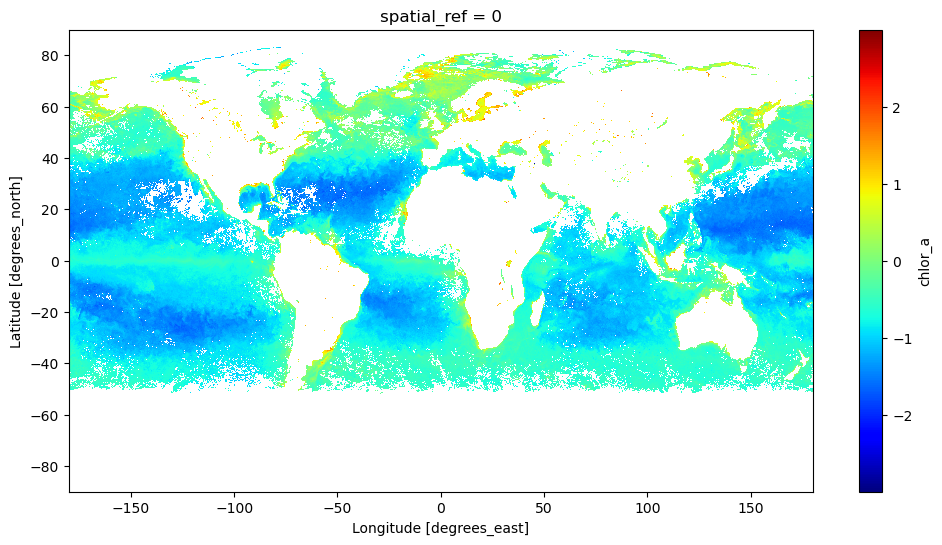

In [8]:
hypercoast.viz_pace_chla(array, cmap="jet", size=6)

### Custermize plots

In [9]:
# Calculate the mean of the 15-day data
array_mean = array.mean('date')
array_mean.attrs.update(
    {
        "long_name": array.attrs["long_name"],
        "units": f'lg({array.attrs["units"]})',
    }
)

In [10]:
# Define the boundary of the area
min_lon = -179     # lower left longitude
min_lat = 75     # lower left latitude !!! note the current lat is reversed, need to fix in the function
max_lon = -140     # upper right longitude
max_lat = 50     # upper right latitude

# Defining the boundaries
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]

# Performing the reduction
array_mean_clip = array_mean.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))

In [11]:
array_mean_clip

<xarray.DataArray 'chlor_a' (lat: 250, lon: 390)> Size: 390kB
dask.array<getitem, shape=(250, 390), dtype=float32, chunksize=(250, 390), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 1kB 74.95 74.85 74.75 74.65 ... 50.25 50.15 50.05
  * lon          (lon) float32 2kB -178.9 -178.9 -178.8 ... -140.2 -140.1 -140.1
    spatial_ref  int64 8B 0
Attributes:
    long_name:  Chlorophyll Concentration, OCI Algorithm
    units:      lg(lg(mg m^-3))

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

def plot_regional_map(dataset, min_lon, max_lon, min_lat, max_lat, 
                 title=None, colormap=cmocean.cm.thermal, vmin=-1.5, vmax=1.5, size=(5, 5), ax=None):
    """
    Plot a dataset within specified lat/lon boundaries.

    Parameters:
    dataset (xarray.DataArray): The data array to plot.
    min_lon (float): Minimum longitude.
    max_lon (float): Maximum longitude.
    min_lat (float): Minimum latitude.
    max_lat (float): Maximum latitude.
    title (str, optional): Title for the plot. Default is None.
    colormap (str, optional): Colormap for the plot. Default is cmocean.cm.thermal.
    vmin (float, optional): Minimum value for the color scale. Default is -1.5.
    vmax (float, optional): Maximum value for the color scale. Default is 1.5.
    size (tuple, optional): Figure size. Default is (5, 5).
    ax (matplotlib.axes._subplots.AxesSubplot, optional): Axis to plot on. Default is None.

    Returns:
    ax: The map handle.
    """
    
    # Calculate central longitude and latitude
    central_longitude = (min_lon + max_lon) / 2
    central_latitude = (min_lat + max_lat) / 2
    
    # Create a new figure if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=size, subplot_kw={'projection': ccrs.LambertConformal(central_longitude=central_longitude, central_latitude=central_latitude)})
    
    # Set extent
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())
    
    # Plotting using Matplotlib
    cf = dataset.plot(
        transform=ccrs.PlateCarree(), cmap=colormap,
        add_colorbar=False, vmin=vmin, vmax=vmax,
        ax=ax
    )
    
    # Color bar
    cbar = plt.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, orientation="horizontal")
    clabel = f"{dataset.long_name}\n{dataset.units}"
    cbar.set_label(clabel, rotation=0, labelpad=5)
    cbar.ax.tick_params(labelsize=8)
    
    # Title
    if title:
        ax.set_title(title)
    
    # Plot lat/lon grid
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.1, color='k', alpha=1, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    # Add coastlines
    ax.coastlines(linewidth=1)
    
    # Show plot if no axis is provided
    if ax is None:
        plt.show()
    
    # Return the map handle
    return ax

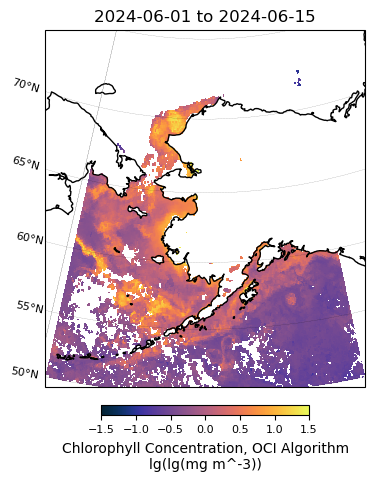

In [13]:
# Plot PACE data
m = plot_regional_map(array_mean_clip, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, size=(5,5))

## Load and plot VIIRS data

There are many different ways to obtain L3 data (e.g., from https://oceancolor.gsfc.nasa.gov/l3/) \
Here we show how to get data from NOAA's ERDDAP server (https://oceanwatch.pifsc.noaa.gov/erddap/index.html)

In [14]:
# import urllib.request 
# url = 'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/noaa_snpp_chla_daily.nc?chlor_a%5B(2024-06-01T12:00:00Z):1:(2024-06-15T12:00:00Z)%5D%5B(0.0):1:(0.0)%5D%5B(77.00625):1:(50.006249999999994)%5D%5B(180.01875):1:(221.98125000000002)%5D'
# urllib.request.urlretrieve(url, "viirs.nc")

In [15]:
viirs_ds = xr.open_dataset('viirs.nc')

In [16]:
viirs_chla = np.log10(viirs_ds['chlor_a'])
# Calculate the temporal mean
viirs_chla_mean = viirs_chla.mean('time')

viirs_chla_mean.attrs.update(
    {
        "long_name": "SNPP VIIRS, L3 Chlorophyll a Concentration",
        "units": 'lg[lg{}]]'.format(viirs_ds['chlor_a'].attrs["units"]),
    }
)

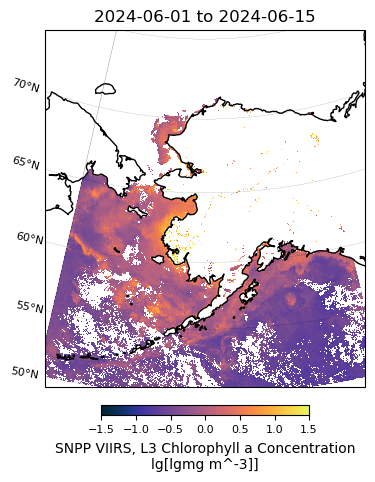

In [17]:
# Plot VIIRS data
m = plot_regional_map(viirs_chla_mean, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, size=(5,5))

## Now let's put them side by side

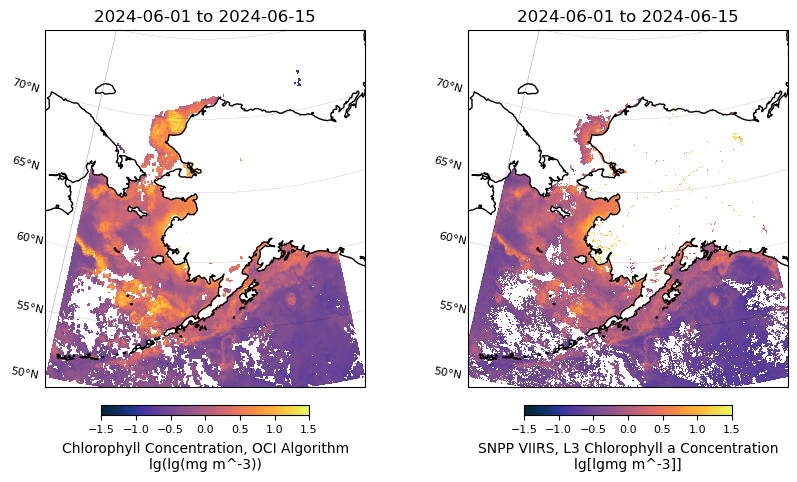

In [19]:
# Calculate central longitude and latitude
central_longitude = (min_lon + max_lon) / 2
central_latitude = (min_lat + max_lat) / 2

# Define project
projection = ccrs.LambertConformal(central_longitude=central_longitude, 
                                   central_latitude=central_latitude)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), 
                        subplot_kw={'projection': projection})

m1 = plot_regional_map(array_mean_clip, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, ax=axs[0])

m2 = plot_regional_map(viirs_chla_mean, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, ax=axs[1])